In [110]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tnrange

sns.set_context('paper', font_scale=1.25)

# Experiment: Linear

In [111]:
# pull things from the files!

n_draws = 500

sim_1 = pd.read_pickle('Data/PPC/exp_linear/sim_1.pkl')
n = len(sim_1)

ppc = np.zeros((n, n_draws))
for ii in range(n_draws):
    f = 'Data/PPC/exp_linear/sim_{}.pkl'.format(ii)
    ppc[:, ii] = pd.read_pickle(f)['arm_sim']
    
ppc_kal = np.zeros((n, n_draws))
for ii in range(n_draws):
    f = 'Data/PPC/exp_linear/sim_kal_{}.pkl'.format(ii)
    ppc_kal[:, ii] = pd.read_pickle(f)['arm_sim']
    
    

Text(0.5,1,'Random')

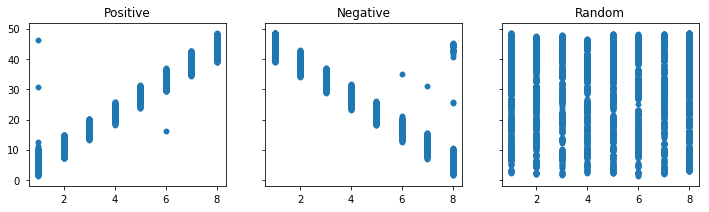

In [74]:
raw_data = sim_1.copy()
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

x = raw_data.loc[(raw_data.cond == 'pos'), 'arm']
y = raw_data.loc[(raw_data.cond == 'pos'), 'out']
axes[0].scatter(x, y)
axes[0].set_title('Positive')

x = raw_data.loc[(raw_data.cond == 'neg'), 'arm']
y = raw_data.loc[(raw_data.cond == 'neg'), 'out']
axes[1].scatter(x, y)
axes[1].set_title('Negative')


x = raw_data.loc[(raw_data.cond == 'ran'), 'arm']
y = raw_data.loc[(raw_data.cond == 'ran'), 'out']
plt.scatter(x, y)
axes[2].set_title('Random')

Text(0.5,1,'Kalman')

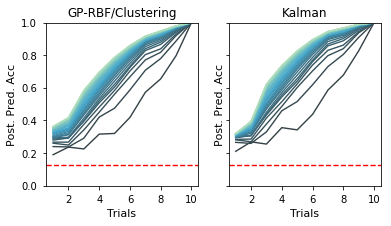

In [75]:
# does the model get better at predicting behavior across rounds?

def ppc_acc_v_round(ppc, raw, ax=None):
    y_true = raw.arm

    df = []
    cc = sns.color_palette("GnBu_d", 31)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    for r in tnrange(1, 31):
        for ii in range(n_draws):
            y_samp = ppc[:, ii] 
            df.append(raw.loc[(y_true == y_samp) & (raw['round'] == r), 'trial'].values)
        y = np.array([np.sum(np.concatenate(df) == ii) for ii in range(1, 11)], dtype=float)
        y /= y.max()
        ax.plot(range(1, 11), y, color=cc[r])
    ax.set_ylabel('Post. Pred. Acc')
    ax.set_xlabel('Trials')
    ax.axhline(y=1./8, color='r', ls='dashed')
    ax.set_ylim([0, 1])
    
    return ax

fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
ax = ppc_acc_v_round(ppc, sim_1, ax=axes[0])
ax.set_title('GP-RBF/Clustering')
ax = ppc_acc_v_round(ppc_kal, sim_1, ax=axes[1])
ax.set_title('Kalman')


Text(0.5,1,'Kalman')

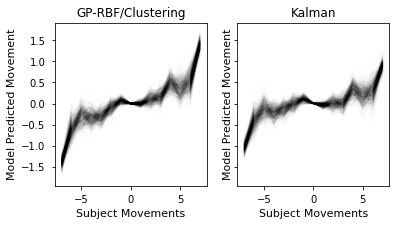

In [76]:
def model_pred_movement(ppc, raw, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 3))

    for ii in tnrange(n_draws):
        y_samp = ppc[:, ii]  
        y = raw.loc[:, 'arm'].values
        rew = raw.loc[:, 'out'].values[:-1]

        move_samp = y_samp[1:] - y_samp[:-1]
        move_true = y[1:] - y[:-1]

        move_samp = move_samp[raw.trial[1:] != 10]
        move_true = move_true[raw.trial[1:] != 10]

        movements = range(np.min(move_true), np.max(move_true)+1)
        model_movements = [np.mean(move_samp[move_true == v])for v in movements]
        model_movements_err = [np.std(move_samp[move_true == v]) for v in movements]

        ax.plot(movements, model_movements, alpha=0.01, color='k')
    # plt.xlim([-7.5, 7.5])
    # plt.ylim([-7.5, 7.5])
    ax.set_xlabel('Subject Movements')
    ax.set_ylabel('Model Predicted Movement')
    return ax
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

ax = model_pred_movement(ppc, sim_1, ax=axes[0])
ax.set_title('GP-RBF/Clustering')
ax = model_pred_movement(ppc_kal, sim_1, ax=axes[1])
ax.set_title('Kalman')

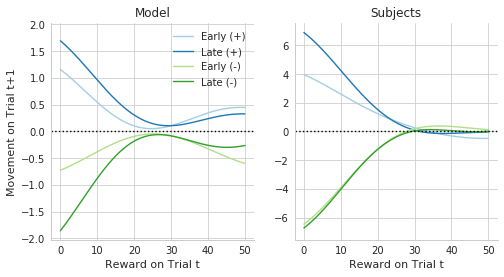

In [77]:
from sklearn.kernel_ridge import KernelRidge

def plot_3(ppc, raw_data, intercept=False, early=5, late=25):
    y_true = raw_data.arm
    cc = sns.color_palette('colorblind')
    
    with sns.axes_style('whitegrid'):
        
        
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))        
        if intercept:
            upper_bound=100
        else:
            upper_bound=50

        def smooth_kernal_ridge(rew, movement):
            clf = KernelRidge(alpha=1.0, kernel='rbf', gamma=.001)
            clf.fit(rew.reshape(-1, 1), movement.reshape(-1, 1))
            x = np.linspace(0, upper_bound, 1000)
            return x, clf.predict(x.reshape(-1, 1)).reshape(-1)
        

        
        def plot_sample_early(ax, cond, color=cc, label=None):

            all_preds = []
            for ii in tnrange(n_draws):
                y_samp = ppc[:, ii]
                y = raw_data.loc[:, 'arm'].values
                rew = raw_data.loc[:, 'out'].values[:-1]
                if intercept:
                    rew = raw_data.loc[:, 'out'].values[:-1] + \
                        raw_data.loc[:, 'int'].values[:-1]

                move_samp = y_samp[1:] - y_samp[:-1]

                vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == cond) & (raw_data['round'][1:] <= early)

                move_samp = move_samp[vec]
                rew = rew[vec]

                idx = np.argsort(rew)
                x = rew[idx]
                _x, y = smooth_kernal_ridge(rew, move_samp)

                all_preds.append(y)
            ax.plot(_x, np.array(all_preds).mean(axis=0), color=color, label=label)

        def plot_sample_late(ax, cond, color=cc, label=None):

            all_preds = []
            for ii in tnrange(n_draws):
                y_samp = ppc[:, ii]
                y = raw_data.loc[:, 'arm'].values
                rew = raw_data.loc[:, 'out'].values[:-1]
                if intercept:
                    rew = raw_data.loc[:, 'out'].values[:-1] + \
                        raw_data.loc[:, 'int'].values[:-1]

                move_samp = y_samp[1:] - y_samp[:-1]

                vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == cond) & (raw_data['round'][1:] > late)

                move_samp = move_samp[vec]
                rew = rew[vec]

                idx = np.argsort(rew)
                x = rew[idx]
                _x, y = smooth_kernal_ridge(rew, move_samp)

                all_preds.append(y)
            ax.plot(_x, np.array(all_preds).mean(axis=0), color=color, label=label)

        cc = sns.color_palette("Paired")
        plot_sample_early(axes[0], 'pos', color=cc[0], label='Early (+)')
        plot_sample_late(axes[0], 'pos', color=cc[1], label='Late (+)')

        plot_sample_early(axes[0], 'neg', color=cc[2], label='Early (-)')
        plot_sample_late(axes[0], 'neg', color=cc[3], label='Late (-)')
        axes[0].legend()
        axes[0].set_title('Model')
        axes[0].set_xlabel('Reward on Trial t')
        axes[0].set_ylabel('Movement on Trial t+1')


        y = raw_data.loc[:, 'arm'].values
        rew = raw_data.loc[:, 'out'].values[:-1]
        if intercept:
            rew = raw_data.loc[:, 'out'].values[:-1] + \
                raw_data.loc[:, 'int'].values[:-1]
        move_true = y[1:] - y[:-1]
        vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == 'pos') & (raw_data['round'][1:] <= early)
        move_true = move_true[vec]
        rew = rew[vec]
        idx = np.argsort(rew)
        x, y = smooth_kernal_ridge(rew[idx], move_true[idx])
        axes[1].plot(x, y, color=cc[0], label='Early (+)')

        y = raw_data.loc[:, 'arm'].values
        rew = raw_data.loc[:, 'out'].values[:-1]
        if intercept:
            rew = raw_data.loc[:, 'out'].values[:-1] + \
                raw_data.loc[:, 'int'].values[:-1]
        move_true = y[1:] - y[:-1]
        vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == 'pos') & (raw_data['round'][1:] > late)
        move_true = move_true[vec]
        rew = rew[vec]
        idx = np.argsort(rew)
        x, y = smooth_kernal_ridge(rew[idx], move_true[idx])
        axes[1].plot(x, y, color=cc[1], label='Late (+)')


        y = raw_data.loc[:, 'arm'].values
        rew = raw_data.loc[:, 'out'].values[:-1]
        if intercept:
            rew = raw_data.loc[:, 'out'].values[:-1] + \
                raw_data.loc[:, 'int'].values[:-1]
        move_true = y[1:] - y[:-1]
        vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == 'neg') & (raw_data['round'][1:] <= early)
        move_true = move_true[vec]
        rew = rew[vec]
        idx = np.argsort(rew)
        x, y = smooth_kernal_ridge(rew[idx], move_true[idx])
        axes[1].plot(x, y, color=cc[2], label='Early (-)')

        y = raw_data.loc[:, 'arm'].values
        rew = raw_data.loc[:, 'out'].values[:-1]
        if intercept:
            rew = raw_data.loc[:, 'out'].values[:-1] + \
                raw_data.loc[:, 'int'].values[:-1]
        move_true = y[1:] - y[:-1]
        vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == 'neg') & (raw_data['round'][1:] > late)
        move_true = move_true[vec]
        rew = rew[vec]
        idx = np.argsort(rew)
        x, y = smooth_kernal_ridge(rew[idx], move_true[idx])
        axes[1].plot(x, y, color=cc[3], label='Late (-)')

        axes[1].set_xlabel('Reward on Trial t')
        axes[1].set_title('Subjects')
        
        for ax in axes:
            ax.axhline(0, color='k', linestyle=':')
            bnd = np.max(np.abs(ax.get_ylim()))
            ax.set_ylim((-bnd, bnd))
            
        sns.despine()

    return fig, axes
fig, axes = plot_3(ppc, sim_1)

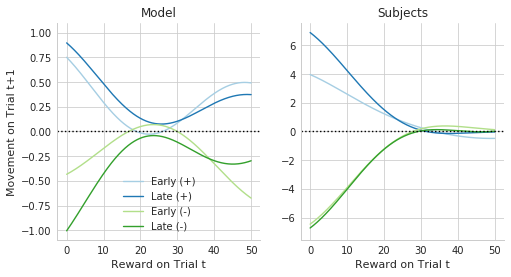

In [84]:
fig, axes = plot_3(ppc_kal, sim_1)

/anaconda3/envs/gp_learning/lib/python2.7/site-packages/ipykernel_launcher.py:49: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



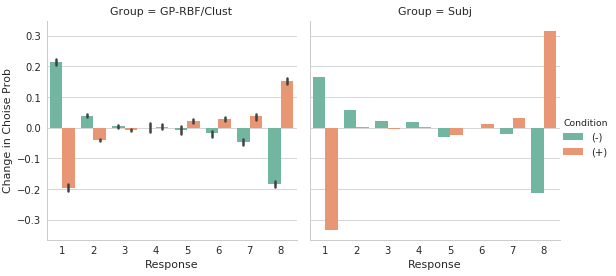

In [78]:
# what is the distribution of choices on trials 1 and 2 for the pos and neg conditions?

def plot_4(ppc, raw_data):
    
    y = raw_data.loc[:, 'arm'].values

    samples = 5

    def get_cmf(cond, trial=1):
        all_preds = []
        for ii in range(samples):
            y_samp = ppc[:, ii]

            vec = (raw_data.trial == trial) & (raw_data.cond == cond)
            y_samp = y_samp[vec]
            all_preds.append([np.sum(np.array(y_samp) == ii) for ii in range(1, 9)])

        all_preds = np.array(all_preds, dtype=float) / np.tile(np.sum(all_preds, axis=1), (8,1)).T
        return all_preds

    def get_cmf_sub(cond, trial=1):
        y = sim_1.arm.values
        vec = (raw_data.trial == trial) & (raw_data.cond == cond)
        y = y[vec]
        all_preds = np.array([np.sum(np.array(y) == ii) for ii in range(1, 9)])
        return all_preds / float(np.sum(all_preds))

    df = pd.concat([pd.DataFrame({
        'Change in Choise Prob': get_cmf('neg', 2).reshape(-1) - get_cmf('neg').reshape(-1),
        'Response': range(1, 9) * samples,
        'Draw': np.reshape([[ii] * 8 for ii in range(samples)], -1),
        'Condition': ['(-)'] * 8 * samples,
        'Group': ['GP-RBF/Clust'] * 8 * samples 
    }), pd.DataFrame({
        'Change in Choise Prob': get_cmf('pos', 2).reshape(-1) - get_cmf('pos').reshape(-1),
        'Response': range(1, 9) * samples,
        'Draw': np.reshape([[ii] * 8 for ii in range(samples)], -1),
        'Condition': ['(+)'] * 8 * samples,
        'Group': ['GP-RBF/Clust'] * 8 * samples,
    }), pd.DataFrame({
        'Change in Choise Prob': get_cmf_sub('pos', 2).reshape(-1) - get_cmf_sub('pos').reshape(-1),
        'Response': range(1, 9),
        'Condition': ['(+)'] * 8,
        'Group': ['Subj'] * 8,
    }), pd.DataFrame({
        'Change in Choise Prob': get_cmf_sub('neg', 2).reshape(-1) - get_cmf_sub('neg').reshape(-1),
        'Response': range(1, 9),
        'Condition': ['(-)'] * 8,
        'Group': ['Subj'] * 8,

    })])

    with sns.axes_style('whitegrid'):
        g = sns.factorplot(data=df, x='Response', y='Change in Choise Prob', hue='Condition', kind='bar',
                           col='Group',
                           palette=sns.color_palette("Set2"))
    return g

g = plot_4(ppc, sim_1)

/anaconda3/envs/gp_learning/lib/python2.7/site-packages/ipykernel_launcher.py:49: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



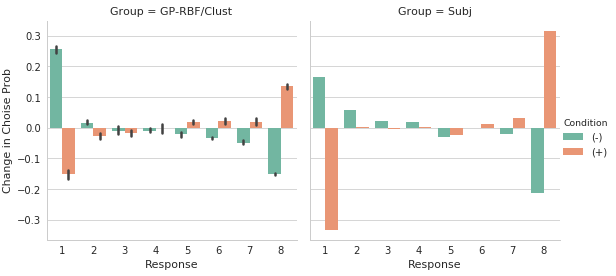

In [79]:
g = plot_4(ppc_kal, sim_1)

/anaconda3/envs/gp_learning/lib/python2.7/site-packages/ipykernel_launcher.py:49: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



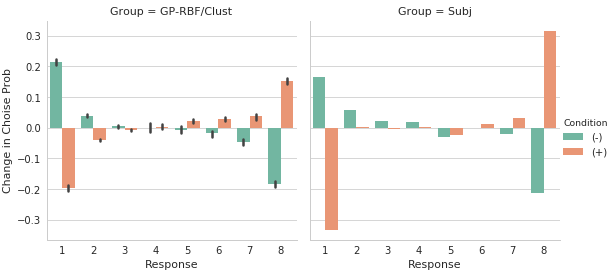

In [80]:
# what is the distribution of choices on trials 1 and 2 for the pos and neg conditions?

def plot_5(ppc, raw_data):
    
    y = raw_data.loc[:, 'arm'].values

    samples = 5

    def get_cmf(cond, trial=1):
        all_preds = []
        for ii in range(samples):
            y_samp = ppc[:, ii]

            vec = (raw_data.trial == trial) & (raw_data.cond == cond)
            y_samp = y_samp[vec]
            all_preds.append([np.sum(np.array(y_samp) == ii) for ii in range(1, 9)])

        all_preds = np.array(all_preds, dtype=float) / np.tile(np.sum(all_preds, axis=1), (8,1)).T
        return all_preds

    def get_cmf_sub(cond, trial=1):
        y = sim_1.arm.values
        vec = (raw_data.trial == trial) & (raw_data.cond == cond)
        y = y[vec]
        all_preds = np.array([np.sum(np.array(y) == ii) for ii in range(1, 9)])
        return all_preds / float(np.sum(all_preds))

    df = pd.concat([pd.DataFrame({
        'Change in Choise Prob': get_cmf('neg', 2).reshape(-1) - get_cmf('neg').reshape(-1),
        'Response': range(1, 9) * samples,
        'Draw': np.reshape([[ii] * 8 for ii in range(samples)], -1),
        'Condition': ['(-)'] * 8 * samples,
        'Group': ['GP-RBF/Clust'] * 8 * samples 
    }), pd.DataFrame({
        'Change in Choise Prob': get_cmf('pos', 2).reshape(-1) - get_cmf('pos').reshape(-1),
        'Response': range(1, 9) * samples,
        'Draw': np.reshape([[ii] * 8 for ii in range(samples)], -1),
        'Condition': ['(+)'] * 8 * samples,
        'Group': ['GP-RBF/Clust'] * 8 * samples,
    }), pd.DataFrame({
        'Change in Choise Prob': get_cmf_sub('pos', 2).reshape(-1) - get_cmf_sub('pos').reshape(-1),
        'Response': range(1, 9),
        'Condition': ['(+)'] * 8,
        'Group': ['Subj'] * 8,
    }), pd.DataFrame({
        'Change in Choise Prob': get_cmf_sub('neg', 2).reshape(-1) - get_cmf_sub('neg').reshape(-1),
        'Response': range(1, 9),
        'Condition': ['(-)'] * 8,
        'Group': ['Subj'] * 8,

    })])

    with sns.axes_style('whitegrid'):
        g = sns.factorplot(data=df, x='Response', y='Change in Choise Prob', hue='Condition', kind='bar',
                           col='Group',
                           palette=sns.color_palette("Set2"))
    return g

g = plot_4(ppc, sim_1)

/anaconda3/envs/gp_learning/lib/python2.7/site-packages/ipykernel_launcher.py:87: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



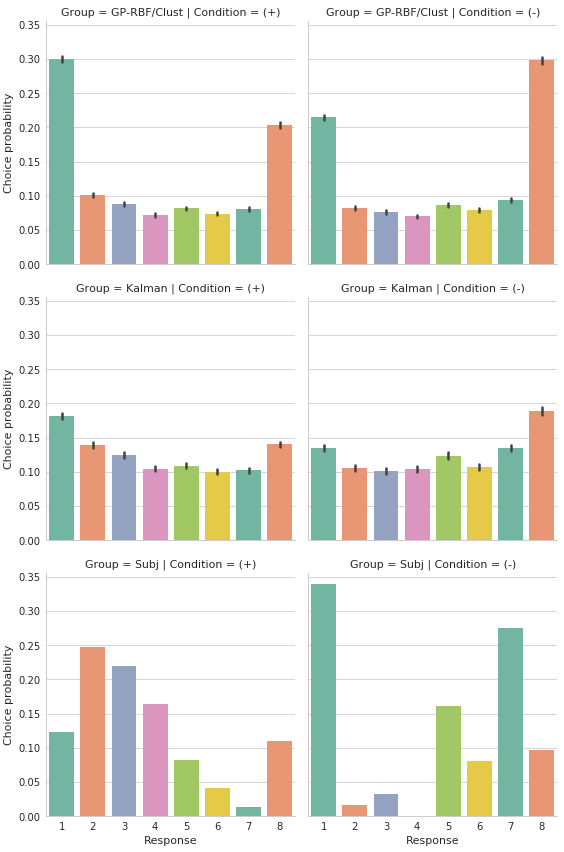

In [90]:
# what is the distribution of choices on trials 1 and 2 for the pos and neg conditions?

def plot_5(ppc, ppc_kal, raw_data, min_round=0):
    
    y = raw_data.loc[:, 'arm'].values

    samples = 500

    def get_cmf_pos(_ppc):
        all_preds = []
        for ii in range(samples):
            y_samp = _ppc[:, ii]
            vec = (raw_data.trial == 2) & (raw_data.cond == 'pos') & (raw_data['round'] > min_round)
            y_samp0 = y_samp[vec]
            vec = (raw_data.trial == 1) & (raw_data.cond == 'pos') & (raw_data['round'] > min_round)
            y_samp1 = y_samp[vec]
            pmf = np.array([np.sum(np.array(y_samp1[y_samp0 ==  1]) == ii) for ii in range(1, 9)], dtype=float)
            all_preds.append(pmf / np.sum(pmf))
        all_preds = np.array(all_preds, dtype=float)
        return all_preds

    def get_cmf_sub_pos():
        y = sim_1.arm.values
        vec = (raw_data.trial == 2) & (raw_data.cond == 'pos') & (raw_data['round'] > min_round)
        y0 = y[vec]
        vec = (raw_data.trial == 1) & (raw_data.cond == 'pos') & (raw_data['round'] > min_round)
        y1 = y[vec]
        pmf = np.array([np.sum(np.array(y1[y0 ==  1]) == ii) for ii in range(1, 9)], dtype=float)
        return pmf / np.sum(pmf)
    
    def get_cmf_neg(_ppc):
        all_preds = []
        for ii in range(samples):
            y_samp = _ppc[:, ii]
            vec = (raw_data.trial == 2) & (raw_data.cond == 'neg') & (raw_data['round'] > min_round)
            y_samp0 = y_samp[vec]
            vec = (raw_data.trial == 1) & (raw_data.cond == 'neg') & (raw_data['round'] > min_round)
            y_samp1 = y_samp[vec]
            pmf = np.array([np.sum(np.array(y_samp1[y_samp0 ==  8]) == ii) for ii in range(1, 9)], dtype=float)
            all_preds.append(pmf / np.sum(pmf))
        all_preds = np.array(all_preds, dtype=float)
        return all_preds

    def get_cmf_sub_neg():
        y = sim_1.arm.values
        vec = (raw_data.trial == 2) & (raw_data.cond == 'neg') & (raw_data['round'] > min_round)
        y0 = y[vec]
        vec = (raw_data.trial == 1) & (raw_data.cond == 'neg') & (raw_data['round'] > min_round)
        y1 = y[vec]
        pmf = np.array([np.sum(np.array(y1[y0 ==  8]) == ii) for ii in range(1, 9)], dtype=float)
        return pmf / np.sum(pmf)

    df = pd.concat([pd.DataFrame({
        'Choice probability': get_cmf_pos(ppc).reshape(-1),
        'Response': range(1, 9) * samples,
        'Draw': np.reshape([[ii] * 8 for ii in range(samples)], -1),
        'Condition': ['(+)'] * 8 * samples,
        'Group': ['GP-RBF/Clust'] * 8 * samples 
    }), pd.DataFrame({
        'Choice probability': get_cmf_pos(ppc_kal).reshape(-1),
        'Response': range(1, 9) * samples,
        'Draw': np.reshape([[ii] * 8 for ii in range(samples)], -1),
        'Condition': ['(+)'] * 8 * samples,
        'Group': ['Kalman'] * 8 * samples 
    }), pd.DataFrame({
        'Choice probability': get_cmf_sub_pos().reshape(-1),
        'Response': range(1, 9),
        'Condition': ['(+)'] * 8,
        'Group': ['Subj'] * 8,

    }),pd.DataFrame({
        'Choice probability': get_cmf_neg(ppc).reshape(-1),
        'Response': range(1, 9) * samples,
        'Draw': np.reshape([[ii] * 8 for ii in range(samples)], -1),
        'Condition': ['(-)'] * 8 * samples,
        'Group': ['GP-RBF/Clust'] * 8 * samples 
    }), pd.DataFrame({
        'Choice probability': get_cmf_neg(ppc_kal).reshape(-1),
        'Response': range(1, 9) * samples,
        'Draw': np.reshape([[ii] * 8 for ii in range(samples)], -1),
        'Condition': ['(-)'] * 8 * samples,
        'Group': ['Kalman'] * 8 * samples 
    }), pd.DataFrame({
        'Choice probability': get_cmf_sub_neg().reshape(-1),
        'Response': range(1, 9),
        'Condition': ['(-)'] * 8,
        'Group': ['Subj'] * 8,

    })])
    
    with sns.axes_style('whitegrid'):
        g = sns.factorplot(data=df, x='Response', y='Choice probability', kind='bar',
                           row='Group', col='Condition',
                           palette=sns.color_palette("Set2"))
    return g

g = plot_5(ppc, ppc_kal, sim_1, min_round=0)

/anaconda3/envs/gp_learning/lib/python2.7/site-packages/ipykernel_launcher.py:86: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



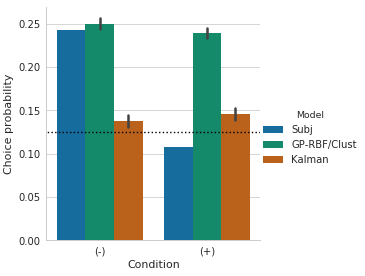

In [116]:
# what is the distribution of choices on trials 1 and 2 for the pos and neg conditions?

def plot_6(ppc, ppc_kal, raw_data, min_round=0):
    
    y = raw_data.loc[:, 'arm'].values

    samples = 500

    def get_cmf_pos(_ppc):
        all_preds = []
        for ii in range(samples):
            y_samp = _ppc[:, ii]
            vec = (raw_data.trial == 2) & (raw_data.cond == 'pos') & (raw_data['round'] > min_round)
            y_samp0 = y_samp[vec]
            vec = (raw_data.trial == 1) & (raw_data.cond == 'pos') & (raw_data['round'] > min_round)
            y_samp1 = y_samp[vec]
            pmf = np.array([np.sum(np.array(y_samp1[y_samp0 ==  1]) == ii) for ii in range(1, 9)], dtype=float)
            all_preds.append(pmf[7] / np.sum(pmf))
        all_preds = np.array(all_preds, dtype=float)
        return all_preds

    def get_cmf_sub_pos():
        y = sim_1.arm.values
        vec = (raw_data.trial == 2) & (raw_data.cond == 'pos') & (raw_data['round'] > min_round)
        y0 = y[vec]
        vec = (raw_data.trial == 1) & (raw_data.cond == 'pos') & (raw_data['round'] > min_round)
        y1 = y[vec]
        pmf = np.array([np.sum(np.array(y1[y0 ==  1]) == ii) for ii in range(1, 9)], dtype=float)
        return pmf[7] / np.sum(pmf)
    
    def get_cmf_neg(_ppc):
        all_preds = []
        for ii in range(samples):
            y_samp = _ppc[:, ii]
            vec = (raw_data.trial == 2) & (raw_data.cond == 'neg') & (raw_data['round'] > min_round)
            y_samp0 = y_samp[vec]
            vec = (raw_data.trial == 1) & (raw_data.cond == 'neg') & (raw_data['round'] > min_round)
            y_samp1 = y_samp[vec]
            pmf = np.array([np.sum(np.array(y_samp1[y_samp0 ==  8]) == ii) for ii in range(1, 9)], dtype=float)
            all_preds.append(pmf[0] / np.sum(pmf))
        all_preds = np.array(all_preds, dtype=float)
        return all_preds

    def get_cmf_sub_neg():
        y = sim_1.arm.values
        vec = (raw_data.trial == 2) & (raw_data.cond == 'neg') & (raw_data['round'] > min_round)
        y0 = y[vec]
        vec = (raw_data.trial == 1) & (raw_data.cond == 'neg') & (raw_data['round'] > min_round)
        y1 = y[vec]
        pmf = np.array([np.sum(np.array(y1[y0 ==  8]) == ii) for ii in range(1, 9)], dtype=float)
        return pmf[0] / np.sum(pmf)
    
#     print get_cmf_pos(ppc)
#     print get_cmf_pos(ppc_kal)
#     print get_cmf_sub_pos()

    df = pd.concat([pd.DataFrame({
        'Choice probability': get_cmf_sub_neg().reshape(-1),
        'Condition': ['(-)'],
        'Model': ['Subj'],

    }),pd.DataFrame({
        'Choice probability': get_cmf_sub_pos().reshape(-1),
        'Condition': ['(+)'],
        'Model': ['Subj'],
    }),
        pd.DataFrame({
        'Choice probability': get_cmf_pos(ppc).reshape(-1),
        'Draw': np.reshape([[ii] for ii in range(samples)], -1),
        'Condition': ['(+)'] * samples,
        'Model': ['GP-RBF/Clust'] * samples 
    }), pd.DataFrame({
        'Choice probability': get_cmf_pos(ppc_kal).reshape(-1),
        'Draw': np.reshape([[ii] for ii in range(samples)], -1),
        'Condition': ['(+)'] * samples,
        'Model': ['Kalman'] * samples 
    }), pd.DataFrame({
        'Choice probability': get_cmf_neg(ppc).reshape(-1),
        'Draw': np.reshape([[ii] for ii in range(samples)], -1),
        'Condition': ['(-)'] * samples,
        'Model': ['GP-RBF/Clust'] * samples 
    }), pd.DataFrame({
        'Choice probability': get_cmf_neg(ppc_kal).reshape(-1),
        'Draw': np.reshape([[ii] for ii in range(samples)], -1),
        'Condition': ['(-)'] * samples,
        'Model': ['Kalman']* samples 
    })
                   ])
    
    with sns.axes_style('whitegrid'):
        g = sns.factorplot(data=df, y='Choice probability', kind='bar',
#                            row='Group',
                           hue='Model', 
                           x='Condition',
                           palette=sns.color_palette("colorblind"))
        
    for ax in g.axes[0]:
        ax.plot([-1, 3], [0.125, 0.125], 'k:')
    return g

g = plot_6(ppc, ppc_kal, sim_1, min_round=15)

In [97]:
g.axes[0]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a2c5f2ad0>,
      dtype=object)

# Experiment: Shifted

The experimental conditions are misslabeled in the dataset for experiment three. For now, estimate them with a niave Bayes classlifier and the geneartive process

Text(0.5,1,'Random')

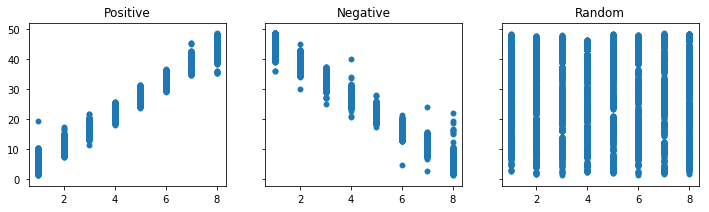

In [118]:
# Hand build a niave Bayes classifier from simluation process
from scipy.stats import norm

### Use my knowledge of how these trials really were created?
def generate_line():
    _min = np.random.uniform(2, 10)
    _max = np.random.uniform(40, 48)
    
    X = np.array([[1, 1], [1, 8]])
    b_hat = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), np.array([_min, _max]))
    return b_hat

n_draw_gen = 5000
pos_slope = np.zeros((n_draw_gen, 8))
x = np.concatenate([np.ones((8, 1)), np.arange(1, 9).reshape(-1, 1)], axis=1)

for ii in range(n_draw_gen):
    beta_hat = generate_line()
    pos_slope[ii, :] = np.matmul(x, beta_hat) + np.random.normal(loc=0.0, scale=0.1, size=8)

neg_slope = pos_slope[:, range(7, -1, -1)]
ran = np.zeros(np.shape(pos_slope))
for ii in range(n_draw_gen):
    ran[ii, :] = pos_slope[ii, np.random.permutation(range(8))]

mu_p = np.mean(pos_slope, axis=0)
std_p = np.std(pos_slope, axis=0)

mu_n = np.mean(neg_slope, axis=0)
std_n = np.std(neg_slope, axis=0)

mu_r = np.mean(ran, axis=0)
std_r = np.std(ran, axis=0)
    
def niave_bayes_classifier(data_frame):
    # classify the original data set 

    _df = data_frame.copy()
    log_prob_p = pd.Series([None] * len(_df), index=_df.index, dtype='float')
    log_prob_r = pd.Series([None] * len(_df), index=_df.index, dtype='float')
    log_prob_n = pd.Series([None] * len(_df), index=_df.index, dtype='float')


    for t in _df.index:
        a = _df.loc[t, 'arm'] - 1
        o = _df.loc[t, 'out']
        log_prob_p[t] = norm.logpdf(o, loc=mu_p[a], scale=std_p[a])
        log_prob_r[t] = norm.logpdf(o, loc=mu_r[a], scale=std_r[a])
        log_prob_n[t] = norm.logpdf(o, loc=mu_n[a], scale=std_n[a])

    _df['log_prob_n'] = log_prob_n
    _df['log_prob_p'] = log_prob_p
    _df['log_prob_r'] = log_prob_r

    # get the total log probability of the observations
    grouped = _df.groupby(['id', 'round']).sum()

    key = {0: 'neg', 1: 'pos', 2: 'ran'}

    new_cond = pd.Series([None] * len(_df), index=_df.index)


    for id0, round0 in grouped.index:
        cond0 = np.argmax(grouped.loc[id0, round0][['log_prob_n', 'log_prob_p', 'log_prob_r']].values)
        _index = _df[(_df.id == id0) & (_df['round'] == round0)].index
        new_cond[_index] = key[cond0]

    return new_cond

exp3_data = pd.read_csv('Data/exp_shifted/datashifted_withoffset.csv')
raw_data = exp3_data.copy()
reconstructed_conditions = niave_bayes_classifier(exp3_data)
raw_data.cond = reconstructed_conditions


fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

x = raw_data.loc[(raw_data.cond == 'pos'), 'arm']
y = raw_data.loc[(raw_data.cond == 'pos'), 'out']
axes[0].scatter(x, y)
axes[0].set_title('Positive')

x = raw_data.loc[(raw_data.cond == 'neg'), 'arm']
y = raw_data.loc[(raw_data.cond == 'neg'), 'out']
axes[1].scatter(x, y)
axes[1].set_title('Negative')


x = raw_data.loc[(raw_data.cond == 'ran'), 'arm']
y = raw_data.loc[(raw_data.cond == 'ran'), 'out']
plt.scatter(x, y)
axes[2].set_title('Random')

In [119]:
# pull things from the files!

# n_draws = 500

sim_1 = pd.read_pickle('Data/PPC/exp_shifted/sim_1.pkl')
sim_1.cond = reconstructed_conditions
n = len(sim_1)

ppc = np.zeros((n, n_draws))
for ii in range(n_draws):
    f = 'Data/PPC/exp_shifted/sim_{}.pkl'.format(ii)
    ppc[:, ii] = pd.read_pickle(f)['arm_sim']

ppc_kal = np.zeros((n, n_draws))
for ii in range(n_draws):
    f = 'Data/PPC/exp_shifted/sim_kal_{}.pkl'.format(ii)
    ppc_kal[:, ii] = pd.read_pickle(f)['arm_sim'] 

/anaconda3/envs/gp_learning/lib/python2.7/site-packages/ipykernel_launcher.py:87: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



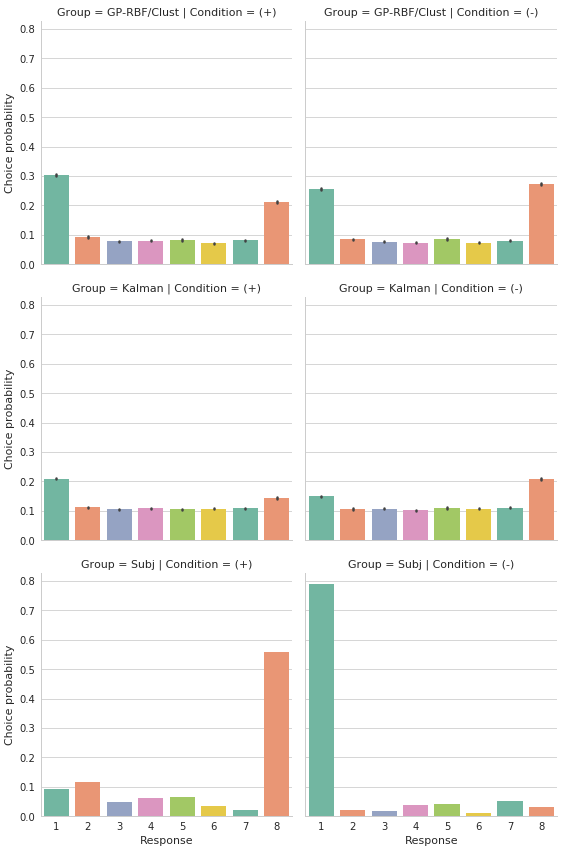

In [120]:
g = plot_5(ppc, ppc_kal, sim_1, min_round=0)

/anaconda3/envs/gp_learning/lib/python2.7/site-packages/ipykernel_launcher.py:86: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



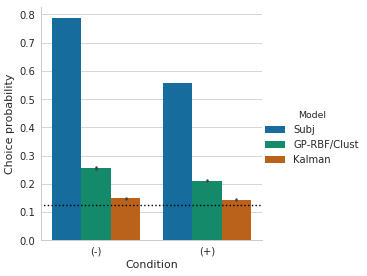

In [121]:
g = plot_6(ppc, ppc_kal, sim_1, min_round=0)

TypeError: 'AxesSubplot' object is not iterable

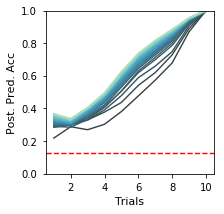

In [122]:
fig, axes = ppc_acc_v_round(ppc, sim_1)

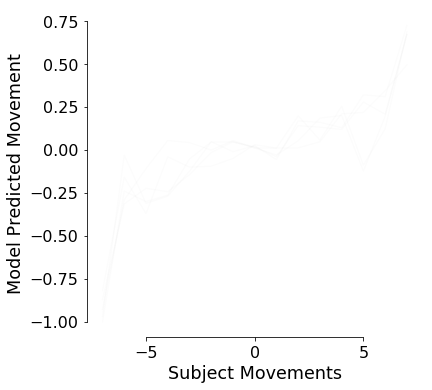

In [12]:
fig, ax = model_pred_movement(ppc, sim_1)

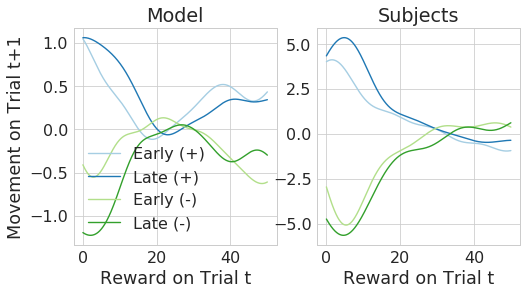

In [13]:
fig, axes = plot_3(ppc, sim_1, early=5, late=25)

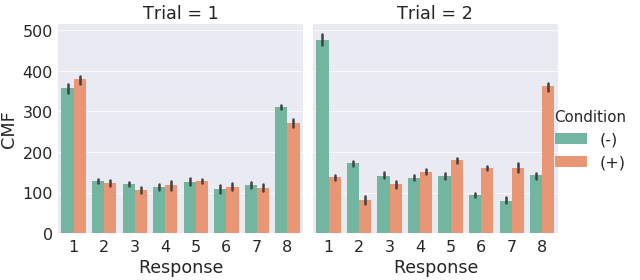

In [15]:
g = plot_4(ppc, sim_1)

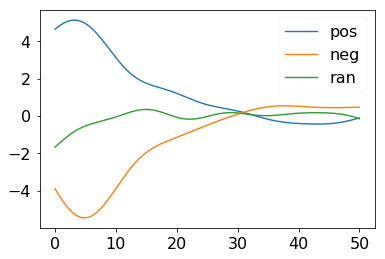

In [16]:
def smooth_kernal_ridge(rew, movement):
    clf = KernelRidge(alpha=1.0, kernel='rbf', gamma=.01)
    clf.fit(rew.reshape(-1, 1), movement.reshape(-1, 1))
    x = np.linspace(0, 50, 1000)
    return x, clf.predict(x.reshape(-1, 1)).reshape(-1)

raw_data = sim_1.copy()
raw_data.loc[:max(raw_data.index)-1, 'Movement'] = raw_data.loc[1:, 'arm'].values - \
    raw_data.loc[:max(raw_data.index)-1, 'arm'].values 

vec = (raw_data.trial != 10) & (raw_data.cond == 'pos')
y = raw_data.loc[vec, 'Movement'].values
x = raw_data.loc[vec, 'out'].values
idx = np.argsort(x)
x, y = smooth_kernal_ridge(x[idx], y[idx])
plt.plot(x, y, label='pos' )


vec = (raw_data.trial != 10) & (raw_data.cond == 'neg')
y = raw_data.loc[vec, 'Movement'].values
x = raw_data.loc[vec, 'out'].values
idx = np.argsort(x)
x, y = smooth_kernal_ridge(x[idx], y[idx])
plt.plot(x, y, label='neg')


vec = (raw_data.trial != 10) & (raw_data.cond == 'ran')
y = raw_data.loc[vec, 'Movement'].values
x = raw_data.loc[vec, 'out'].values
idx = np.argsort(x)
x, y = smooth_kernal_ridge(x[idx], y[idx])
plt.plot(x, y, label='ran')

plt.legend()


In [17]:
vec = (raw_data.trial != 10) & (raw_data.cond == 'pos')
y = raw_data.loc[vec, 'Movement'].values
x = raw_data.loc[vec, 'out'].values
np.corrcoef(x, y)

array([[ 1.        , -0.60192471],
       [-0.60192471,  1.        ]])

In [25]:
vec = (raw_data.trial != 10) & (raw_data.cond == 'neg')
y = raw_data.loc[vec, 'Movement'].values
x = raw_data.loc[vec, 'out'].values
np.corrcoef(x, y)

array([[1.        , 0.00260474],
       [0.00260474, 1.        ]])

In [26]:
print len(set(raw_data['id']))
print len(set(sim_1['id']))

131
131


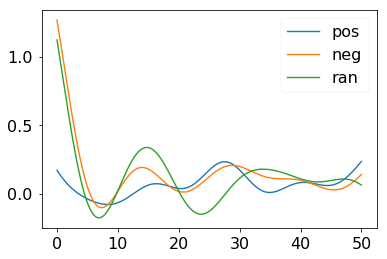

In [27]:


vec = (raw_data.trial != 10) & (raw_data.cond == 'pos')
y = raw_data.loc[vec, 'Movement'].values
x = raw_data.loc[vec, 'out'].values
idx = np.argsort(x)
x, y = smooth_kernal_ridge(x[idx], y[idx])
plt.plot(x, y, label='pos' )


vec = (raw_data.trial != 10) & (raw_data.cond == 'neg')
y = raw_data.loc[vec, 'Movement'].values
x = raw_data.loc[vec, 'out'].values
idx = np.argsort(x)
x, y = smooth_kernal_ridge(x[idx], y[idx])
plt.plot(x, y, label='neg')


vec = (raw_data.trial != 10) & (raw_data.cond == 'ran')
y = raw_data.loc[vec, 'Movement'].values
x = raw_data.loc[vec, 'out'].values
idx = np.argsort(x)
x, y = smooth_kernal_ridge(x[idx], y[idx])
plt.plot(x, y, label='ran')

plt.legend()

Text(0.5,1,'Random')

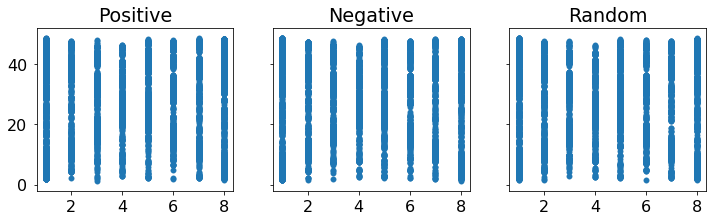

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

x = raw_data.loc[(raw_data.cond == 'pos'), 'arm']
y = raw_data.loc[(raw_data.cond == 'pos'), 'out']
axes[0].scatter(x, y)
axes[0].set_title('Positive')

x = raw_data.loc[(raw_data.cond == 'neg'), 'arm']
y = raw_data.loc[(raw_data.cond == 'neg'), 'out']
axes[1].scatter(x, y)
axes[1].set_title('Negative')


x = raw_data.loc[(raw_data.cond == 'ran'), 'arm']
y = raw_data.loc[(raw_data.cond == 'ran'), 'out']
plt.scatter(x, y)
axes[2].set_title('Random')

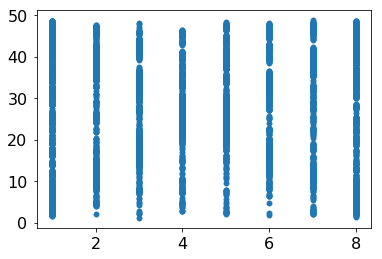

In [29]:
x = raw_data.loc[(raw_data.cond == 'pos'), 'arm']
y = raw_data.loc[(raw_data.cond == 'pos'), 'out']
plt.scatter(x, y)

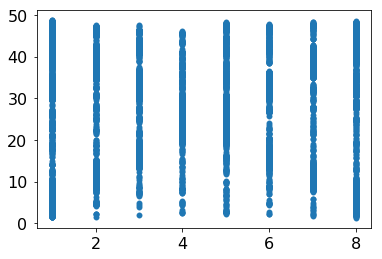

In [30]:
x = raw_data.loc[(raw_data.cond == 'neg'), 'arm']
y = raw_data.loc[(raw_data.cond == 'neg'), 'out']
plt.scatter(x, y)

so, I don't know what the real condition labels are so I'll just fit a classifier from experiment 1


In [31]:
exp1_data = pd.read_pickle('Data/PPC/exp_linear/sim_1.pkl')
# construct training examples from the data.
y = exp1_data.loc[exp1_data.trial == 1, 'cond'].values

cond_key = {'ran': 0, 'pos': 1, 'neg': 2}
y_train = np.array([cond_key[y0] for y0 in y])


def make_one_hot(t):
    a = exp1_data.loc[exp1_data.trial == t, 'arm'].values - 1
    r = exp1_data.loc[exp1_data.trial == t, 'out'].values
    one_hot = np.zeros((len(a), 8))
    for ii, (a0, r0) in enumerate(zip(a, r)):
        one_hot[ii, a0] = r0
    return one_hot
X_train = np.concatenate([make_one_hot(8) for t in range(1, 11)], axis=1)

In [69]:
from sklearn.svm import SVC
clf = SVC(kernel = 'linear', C = 2).fit(X_train, y_train)
print clf.score(X_train, y_train)

0.7553459119496856


In [63]:
clf = SVC(kernel = 'rbf', C = 2).fit(X_train, y_train)
print clf.score(X_train, y_train)

0.8704402515723271


In [34]:
from sklearn.svm import LinearSVC


0.6974842767295597


In [35]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 10).fit(X_train, y_train)
print knn.score(X_train, y_train)

0.8738993710691824


In [36]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train, y_train) 
# accuracy on X_test
print gnb.score(X_train, y_train)

0.7245283018867924


In [37]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
print clf.score(X_train, y_train)

0.9820754716981132


Looks like the random forest classifier is the way to go!

0.7930817610062894


Text(0.5,1,'Random')

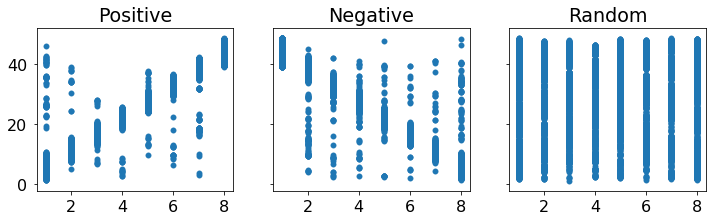

In [86]:
knn = KNeighborsClassifier(n_neighbors = 10).fit(X_train, y_train)
print clf.score(X_train, y_train)

exp3_data = pd.read_pickle('Data/PPC/exp_shifted//sim_1.pkl')
# construct training examples from the data.
y = exp3_data.loc[exp3_data.trial == 1, 'cond'].values

y_test = np.array([cond_key[y0] for y0 in y])


def make_one_hot(t):
    a = exp3_data.loc[exp3_data.trial == t, 'arm'].values - 1
    r = exp3_data.loc[exp3_data.trial == t, 'out'].values
    one_hot = np.zeros((len(a), 8))
    for ii, (a0, r0) in enumerate(zip(a, r)):
        one_hot[ii, a0] = r0
    return one_hot
X_test = np.concatenate([make_one_hot(8) for t in range(1, 11)], axis=1)

reverse_key = {v: k for k, v in cond_key.iteritems()}

new_conditions = [reverse_key[k0] for k0 in clf.predict(X_test)]
new_cond_vec = np.concatenate([np.array([c] * 10, dtype=object) for c in new_conditions])



exp3_data['new_cond'] = new_cond_vec
raw_data = exp3_data.copy()


fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

x = raw_data.loc[(raw_data.new_cond == 'pos'), 'arm']
y = raw_data.loc[(raw_data.new_cond == 'pos'), 'out']
axes[0].scatter(x, y)
axes[0].set_title('Positive')

x = raw_data.loc[(raw_data.new_cond == 'neg'), 'arm']
y = raw_data.loc[(raw_data.new_cond == 'neg'), 'out']
axes[1].scatter(x, y)
axes[1].set_title('Negative')


x = raw_data.loc[(raw_data.new_cond == 'ran'), 'arm']
y = raw_data.loc[(raw_data.new_cond == 'ran'), 'out']
plt.scatter(x, y)
axes[2].set_title('Random')

0.7930817610062894


Text(0.5,1,'Random')

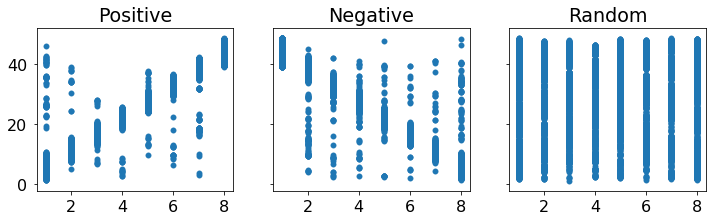

In [88]:
clf = SVC(kernel='rbf', C=0.0001).fit(X_train, y_train)
print clf.score(X_train, y_train)

exp3_data = pd.read_pickle('Data/PPC/exp_shifted//sim_1.pkl')
# construct training examples from the data.
y = exp3_data.loc[exp3_data.trial == 1, 'cond'].values

y_test = np.array([cond_key[y0] for y0 in y])


def make_one_hot(t):
    a = exp3_data.loc[exp3_data.trial == t, 'arm'].values - 1
    r = exp3_data.loc[exp3_data.trial == t, 'out'].values
    one_hot = np.zeros((len(a), 8))
    for ii, (a0, r0) in enumerate(zip(a, r)):
        one_hot[ii, a0] = r0
    return one_hot
X_test = np.concatenate([make_one_hot(8) for t in range(1, 11)], axis=1)

reverse_key = {v: k for k, v in cond_key.iteritems()}

new_conditions = [reverse_key[k0] for k0 in clf.predict(X_test)]
new_cond_vec = np.concatenate([np.array([c] * 10, dtype=object) for c in new_conditions])



exp3_data['new_cond'] = new_cond_vec
raw_data = exp3_data.copy()


fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

x = raw_data.loc[(raw_data.new_cond == 'pos'), 'arm']
y = raw_data.loc[(raw_data.new_cond == 'pos'), 'out']
axes[0].scatter(x, y)
axes[0].set_title('Positive')

x = raw_data.loc[(raw_data.new_cond == 'neg'), 'arm']
y = raw_data.loc[(raw_data.new_cond == 'neg'), 'out']
axes[1].scatter(x, y)
axes[1].set_title('Negative')


x = raw_data.loc[(raw_data.new_cond == 'ran'), 'arm']
y = raw_data.loc[(raw_data.new_cond == 'ran'), 'out']
plt.scatter(x, y)
axes[2].set_title('Random')

/anaconda3/envs/gp_learning/lib/python2.7/site-packages/ipykernel_launcher.py:73: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


Text(0.5,1,'Random')

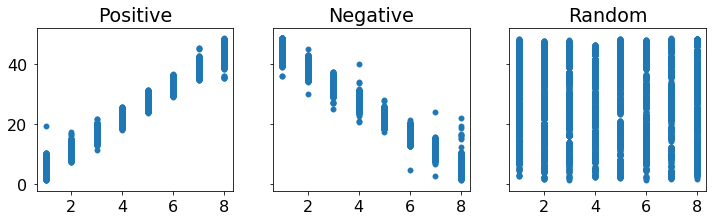

In [99]:
# Hand build a niave Bayes classifier from simluation process
from scipy.stats import norm

### Use my knowledge of how these trials really were created?
def generate_line():
    _min = np.random.uniform(2, 10)
    _max = np.random.uniform(40, 48)
    
    X = np.array([[1, 1], [1, 8]])
    b_hat = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), np.array([_min, _max]))
    return b_hat

n_draws = 5000
pos_slope = np.zeros((n_draws, 8))
x = np.concatenate([np.ones((8, 1)), np.arange(1, 9).reshape(-1, 1)], axis=1)

for ii in range(n_draws):
    beta_hat = generate_line()
    pos_slope[ii, :] = np.matmul(x, beta_hat) + np.random.normal(loc=0.0, scale=0.1, size=8)

neg_slope = pos_slope[:, range(7, -1, -1)]
# randomly shuffle
ran = np.zeros(np.shape(pos_slope))
for ii in range(n_draws):
    ran[ii, :] = pos_slope[ii, np.random.permutation(range(8))]

mu_p = np.mean(pos_slope, axis=0)
std_p = np.std(pos_slope, axis=0)

mu_n = np.mean(neg_slope, axis=0)
std_n = np.std(neg_slope, axis=0)

mu_r = np.mean(ran, axis=0)
std_r = np.std(ran, axis=0)
    
def niave_bayes_classifier(data_frame):
    # classify the original data set 

    _df = data_frame.copy()
    log_prob_p = pd.Series([None] * len(_df), index=_df.index, dtype='float')
    log_prob_r = pd.Series([None] * len(_df), index=_df.index, dtype='float')
    log_prob_n = pd.Series([None] * len(_df), index=_df.index, dtype='float')


    for t in _df.index:
        a = _df.loc[t, 'arm'] - 1
        o = _df.loc[t, 'out']
        log_prob_p[t] = norm.logpdf(o, loc=mu_p[a], scale=std_p[a])
        log_prob_r[t] = norm.logpdf(o, loc=mu_r[a], scale=std_r[a])
        log_prob_n[t] = norm.logpdf(o, loc=mu_n[a], scale=std_n[a])

    _df['log_prob_n'] = log_prob_n
    _df['log_prob_p'] = log_prob_p
    _df['log_prob_r'] = log_prob_r

    # get the total log probability of the observations
    grouped = _df.groupby(['id', 'round']).sum()

    key = {0: 'neg', 1: 'pos', 2: 'ran'}

    new_cond = pd.Series([None] * len(_df), index=_df.index)


    for id0, round0 in grouped.index:
        cond0 = np.argmax(grouped.loc[id0, round0][['log_prob_n', 'log_prob_p', 'log_prob_r']].values)
        _index = _df[(_df.id == id0) & (_df['round'] == round0)].index
        new_cond[_index] = key[cond0]

    return new_cond

exp3_data = pd.read_csv('Data/exp_shifted/datashifted_withoffset.csv')
raw_data = exp3_data.copy()
raw_data.new_cond  = niave_bayes_classifier(exp3_data)


fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

x = raw_data.loc[(raw_data.new_cond == 'pos'), 'arm']
y = raw_data.loc[(raw_data.new_cond == 'pos'), 'out']
axes[0].scatter(x, y)
axes[0].set_title('Positive')

x = raw_data.loc[(raw_data.new_cond == 'neg'), 'arm']
y = raw_data.loc[(raw_data.new_cond == 'neg'), 'out']
axes[1].scatter(x, y)
axes[1].set_title('Negative')


x = raw_data.loc[(raw_data.new_cond == 'ran'), 'arm']
y = raw_data.loc[(raw_data.new_cond == 'ran'), 'out']
plt.scatter(x, y)
axes[2].set_title('Random')

In [101]:
raw_data.new_cond = niave_bayes_classifier(raw_data)
raw_data.loc[:max(raw_data.index)-1, 'Movement'] = raw_data.loc[1:, 'arm'].values - \
    raw_data.loc[:max(raw_data.index)-1, 'arm'].values 
vec = (raw_data.trial != 10) & (raw_data.new_cond == 'pos')
y = raw_data.loc[vec, 'Movement'].values
x = raw_data.loc[vec, 'out'].values
np.corrcoef(x, y)

array([[ 1.        , -0.60192471],
       [-0.60192471,  1.        ]])

In [102]:
raw_data.loc[:max(raw_data.index)-1, 'Movement'] = raw_data.loc[1:, 'arm'].values - \
    raw_data.loc[:max(raw_data.index)-1, 'arm'].values 
vec = (raw_data.trial != 10) & (raw_data.new_cond == 'neg')
y = raw_data.loc[vec, 'Movement'].values
x = raw_data.loc[vec, 'out'].values
np.corrcoef(x, y)

array([[1.       , 0.5906017],
       [0.5906017, 1.       ]])

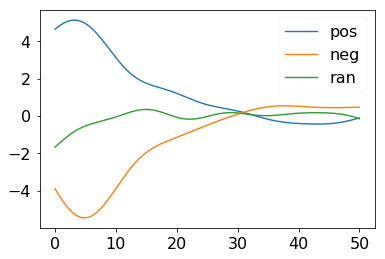

In [103]:
vec = (raw_data.trial != 10) & (raw_data.new_cond == 'pos')
y = raw_data.loc[vec, 'Movement'].values
x = raw_data.loc[vec, 'out'].values
idx = np.argsort(x)
x, y = smooth_kernal_ridge(x[idx], y[idx])
plt.plot(x, y, label='pos' )


vec = (raw_data.trial != 10) & (raw_data.new_cond == 'neg')
y = raw_data.loc[vec, 'Movement'].values
x = raw_data.loc[vec, 'out'].values
idx = np.argsort(x)
x, y = smooth_kernal_ridge(x[idx], y[idx])
plt.plot(x, y, label='neg')


vec = (raw_data.trial != 10) & (raw_data.new_cond == 'ran')
y = raw_data.loc[vec, 'Movement'].values
x = raw_data.loc[vec, 'out'].values
idx = np.argsort(x)
x, y = smooth_kernal_ridge(x[idx], y[idx])
plt.plot(x, y, label='ran')

plt.legend()

Index([u'id', u'trial', u'round', u'arm', u'out', u'int', u'cond',
       u'Movement'],
      dtype='object')


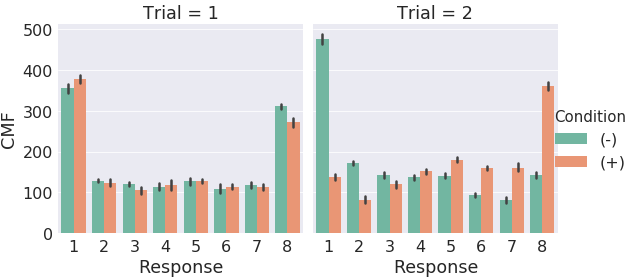

In [104]:
# what is the distribution of choices on trials 1 and 2 for the pos and neg conditions?

def plot_4a(ppc, raw_data):

    y = raw_data.loc[:, 'arm'].values
    print raw_data.columns

    samples = 5

    def get_cmf(cond, trial=1):
        all_preds = []
        for ii in range(samples):
            y_samp = ppc[:, ii]

            vec = (raw_data.trial == trial) & (raw_data.new_cond == cond)
            y_samp = y_samp[vec]
            all_preds.append([np.sum(np.array(y_samp) == ii) for ii in range(1, 9)])

        all_preds = np.array(all_preds, dtype=float) #/ np.sum(all_preds, axis=0)
        return all_preds

    df = pd.concat([pd.DataFrame({
        'CMF': get_cmf('neg').reshape(-1),
        'Response': range(1, 9) * samples,
        'Draw': np.reshape([[ii] * 8 for ii in range(samples)], -1),
        'Condition': ['(-)'] * 8 * samples,
        'Trial': [1] * 8 * samples 
    }), pd.DataFrame({
        'CMF': get_cmf('pos').reshape(-1),
        'Response': range(1, 9) * samples,
        'Draw': np.reshape([[ii] * 8 for ii in range(samples)], -1),
        'Condition': ['(+)'] * 8 * samples,
        'Trial': [1] * 8 * samples 
    }), pd.DataFrame({
        'CMF': get_cmf('neg', 2).reshape(-1),
        'Response': range(1, 9) * samples,
        'Draw': np.reshape([[ii] * 8 for ii in range(samples)], -1),
        'Condition': ['(-)'] * 8 * samples,
        'Trial': [2] * 8 * samples 
    }), pd.DataFrame({
        'CMF': get_cmf('pos', 2).reshape(-1),
        'Response': range(1, 9) * samples,
        'Draw': np.reshape([[ii] * 8 for ii in range(samples)], -1),
        'Condition': ['(+)'] * 8 * samples,
        'Trial': [2] * 8 * samples 
    })])

    with sns.axes_style('darkgrid'):
        g = sns.factorplot(data=df, x='Response', y='CMF', hue='Condition', kind='bar', 
                       col='Trial', palette=sns.color_palette("Set2"))
    return g

g = plot_4a(ppc, raw_data)

In [105]:
sim_1

,id,trial,round,arm,out,int,cond,arm_sim
0,1,1,1,1,10.214093,30.695702,ran,7
1,1,2,1,1,10.301097,30.695702,ran,6
2,1,3,1,1,9.843546,30.695702,ran,1
3,1,4,1,1,9.347668,30.695702,ran,4
4,1,5,1,1,9.830430,30.695702,ran,1
5,1,6,1,1,9.407655,30.695702,ran,2
6,1,7,1,1,9.596512,30.695702,ran,8
7,1,8,1,1,9.639826,30.695702,ran,1
8,1,9,1,1,9.950084,30.695702,ran,1
9,1,10,1,1,9.731273,30.695702,ran,1


In [ ]:
from tqdm import tnrange
def plot_3(ppc, raw_data):
    y_true = raw_data.arm
    cc = sns.color_palette('colorblind')
    
    with sns.axes_style('darkgrid'):
        
        
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        # def smooth(y, sigma=2):
        #     gx = np.arange(-3*sigma, 3*sigma, 0.1)
        #     gaussian = np.exp(-(x/sigma)**2/2)
        #     y_smooth = np.convolve(y, gaussian, mode='same')
        #     return y_smooth

        def smooth(y, box_pts):
            box = np.ones(box_pts)/box_pts
            y_smooth = np.convolve(y, box, mode='same')
            return y_smooth

        def plot_sample_early(ax, cond, color=cc, label=None):

            all_preds = []
            for ii in tnrange(n_draws):
                y_samp = ppc[:, ii]
                y = raw_data.loc[:, 'arm'].values
                rew = raw_data.loc[:, 'out'].values[:-1]

                move_samp = y_samp[1:] - y_samp[:-1]

                vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == cond) & (raw_data['round'][1:] <= 5)

                move_samp = move_samp[vec]
                rew = rew[vec]

                idx = np.argsort(rew)
                x = rew[idx]
                y = smooth(move_samp[idx], 200)

                all_preds.append(y)
            ax.plot(x, np.array(all_preds).mean(axis=0), color=color, label=label)

        def plot_sample_late(ax, cond, color=cc, label=None):

            all_preds = []
            for ii in tnrange(n_draws):
                y_samp = ppc[:, ii]
                y = raw_data.loc[:, 'arm'].values
                rew = raw_data.loc[:, 'out'].values[:-1]

                move_samp = y_samp[1:] - y_samp[:-1]

                vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == cond) & (raw_data['round'][1:] > 20)

                move_samp = move_samp[vec]
                rew = rew[vec]

                idx = np.argsort(rew)
                x = rew[idx]
                y = smooth(move_samp[idx], 200)

                all_preds.append(y)
            ax.plot(x, np.array(all_preds).mean(axis=0), color=color, label=label)

        cc = sns.color_palette("Paired")
        plot_sample_early(axes[0], 'pos', color=cc[0], label='Early (+)')
        plot_sample_late(axes[0], 'pos', color=cc[1], label='Late (+)')

        plot_sample_early(axes[0], 'neg', color=cc[2], label='Early (-)')
        plot_sample_late(axes[0], 'neg', color=cc[3], label='Late (-)')
        axes[0].legend()
        axes[0].set_title('Model')
        axes[0].set_xlabel('Reward on Trial t')
        axes[0].set_ylabel('Movement on Trial t+1')


        y = raw_data.loc[:, 'arm'].values
        rew = raw_data.loc[:, 'out'].values[:-1]
        move_true = y[1:] - y[:-1]
        vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == 'pos') & (raw_data['round'][1:] <= 5)
        move_true = move_true[vec]
        rew = rew[vec]
        idx = np.argsort(rew)
        x = rew[idx]
        y = smooth(move_true[idx], 200)
        axes[1].plot(x, y, color=cc[0], label='Early (+)')

        y = raw_data.loc[:, 'arm'].values
        rew = raw_data.loc[:, 'out'].values[:-1]
        move_true = y[1:] - y[:-1]
        vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == 'pos') & (raw_data['round'][1:] > 20)
        move_true = move_true[vec]
        rew = rew[vec]
        idx = np.argsort(rew)
        x = rew[idx]
        y = smooth(move_true[idx], 200)
        axes[1].plot(x, y, color=cc[1], label='Late (+)')


        y = raw_data.loc[:, 'arm'].values
        rew = raw_data.loc[:, 'out'].values[:-1]
        move_true = y[1:] - y[:-1]
        vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == 'neg') & (raw_data['round'][1:] <= 5)
        move_true = move_true[vec]
        rew = rew[vec]
        idx = np.argsort(rew)
        x = rew[idx]
        y = smooth(move_true[idx], 200)
        axes[1].plot(x, y, color=cc[2], label='Early (-)')

        y = raw_data.loc[:, 'arm'].values
        rew = raw_data.loc[:, 'out'].values[:-1]
        move_true = y[1:] - y[:-1]
        vec = (raw_data.trial[1:] != 10) & (raw_data.cond[1:] == 'neg') & (raw_data['round'][1:] > 20)
        move_true = move_true[vec]
        rew = rew[vec]
        idx = np.argsort(rew)
        x = rew[idx]
        y = smooth(move_true[idx], 200)
        axes[1].plot(x, y, color=cc[3], label='Late (-)')

        axes[1].set_xlabel('Reward on Trial t')
        axes[1].set_title('Subjects')

    return fig, axes
fig, axes = plot_3(ppc, sim_1)

In [ ]:
# does the model get better at predicting behavior across rounds?

def ppc_acc_v_round_a(ppc, raw):
    y_true = raw.arm

    df = []
    cc = sns.color_palette("GnBu_d", 31)
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))


    # first plot
    ax = axes[0]
    for r in range(1, 31):
        for ii in range(n_draws):
            y_samp = ppc[:, ii] 
            df.append(raw.loc[(y_true == y_samp) & (raw['round'] == r), 'trial'].values)
        y = np.array([np.sum(np.concatenate(df) == ii) for ii in range(1, 11)], dtype=float)
        y /= y.max()
        ax.plot(range(1, 11), y, color=cc[r])
    ax.set_ylabel('Posterior Predictive Accuracy')
    ax.set_xlabel('Trials')
    ax.axhline(y=1./8, color='r', ls='dashed')
    ax.set_ylim([0, 1])


    # second plot
    df = []
    cc = sns.color_palette("colorblind")
    ax = axes[1]
    for jj, cond in enumerate(['ran', 'pos', 'neg']):
        for ii in range(n_draws):
            y_samp = ppc[:, ii] 
            df.append(raw.loc[(y_true == y_samp) & (raw['new_cond'] == cond), 
                                   'trial'].values)
        y = np.array([np.sum(np.concatenate(df) == ii) for ii in range(1, 11)], dtype=float)
        y /= y.max()
        ax.plot(range(1, 11), y, color=cc[jj], label=cond)
    ax.legend()
    ax.set_ylabel('Posterior Predictive Accuracy')
    ax.set_xlabel('Trials')
    ax.axhline(y=1./8, color='r', ls='dashed')
    ax.set_ylim([0, 1])
    
    return fig, axes

fig, axes = ppc_acc_v_round(ppc, sim_1)

# plt.savefig('Exp1_ppc_acc_by_time.png', dpi=300)
# plt.savefig('Exp1_ppc_acc_by_time.pdf', dpi=300)